# Distribution fitting with pytorch 

## Overview 
This is a POC of using pytorch to do distribution fitting. This might be useful because it might give us more control over things like parameter initialization, learning rate, and optimization configuration. Also, it makes it easy to track how estimates change during the optimization process. This can help us identify cases where we're getting stuck in local minima. 

- Use the likelihood function of weibull 2p as the loss function 
- The "model" is really just the shape and scale params. During training, we run N iterations. In each iteration, we use the current estimated params to evaluate the loss, calculate gradient, and take an optimization step. 
- After some experimentation, the following config seems to work well: 
  - Initialize weights/params with `weights = torch.distributions.Uniform(0, 4).sample((2,))`
  - Use optimizer `torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)`
  - Use n=2000 iterations in training loop (similar to epochs in more standard ML problems)


Other things to try: 
- Direct comparison with scipy and reliability fits
- For both LBFGS and Adam, how to deal with the case where param estimate becomes negative? When that happens at a certain optimization step, the loss for that step in nan, and then all further steps fail.
- Check why Adam can't deal estimate large scale values (larger than 1.0). ~Confirm that LBFGS can.~ 
- Confirm that it makes sense that the loss function can become negative. In most of the good fits I see, this is the case. 
- How to deal with the case where some infant mortality "pollutes" an otherwise wearout curve? Should we do 2 fits: one on full data, one on data from in \[median/5 to max\], then compare the shapes? If there's a big change, most likely a superposition? 
- Set up tracking of validation loss + early stopping
- Fit mixtures of Weibulls instead of single weibulls. See function `weibull_mixture_nll` below. We would also have to change the `Model` class to have six weights: `p1, p2, shape1, shape2, scale1, scale2`. However, keep in mind that the goal is not perfect fit. Focus on interpretability and business purpose over perfect fit. 





## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 100
shape = 4
scale = 10

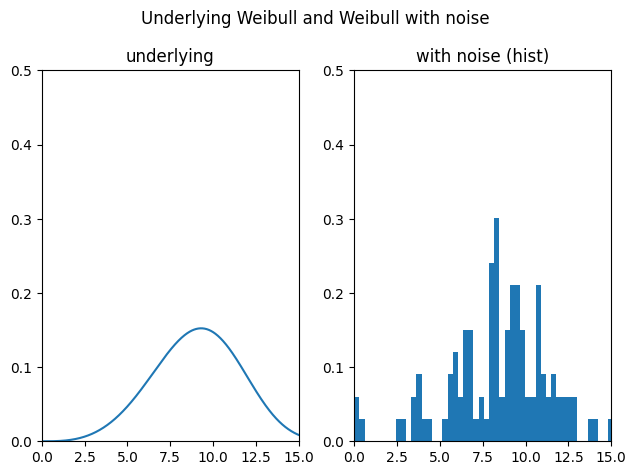

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

right_truncate = False  
trunc_limit = scale + .5
if right_truncate: 
    weibull_data = weibull_data[weibull_data < trunc_limit]
    
add_infant_mortality = True 
im_shape = .5
im_scale = scale/2
im_num_points = int(n/10)
if add_infant_mortality: 
    weibull_data = np.concatenate([weibull_data, weibull_min.rvs(c=im_shape, scale=im_scale, size=im_num_points)]) 


#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 25, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=50, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 15)
    ax[idx].set_ylim(0, .5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

# set up tensor for pytorch ops 
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

### Use left truncation to get a separate fit without possible infant mort overlapping wearout 

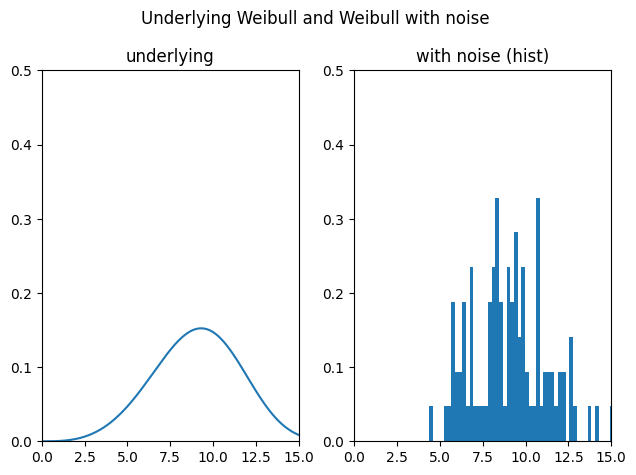

In [4]:
lower = np.median(weibull_data)/2
weibull_data_left_trunc = weibull_data[weibull_data > lower]


#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 25, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data_left_trunc, bins=50, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 15)
    ax[idx].set_ylim(0, .5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()


# set up tensor for pytorch ops 
weibull_left_trunc_tensor = torch.tensor(weibull_data_left_trunc, dtype=float).reshape(-1,1)

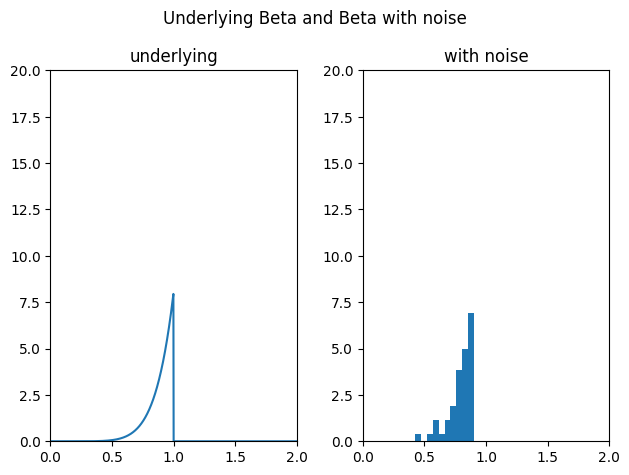

In [5]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

right_truncate = True 
trunc_limit = .9
if right_truncate: 
    beta_data = beta_data[beta_data < trunc_limit]


#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

# set up tensor for pytorch ops 
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

****
# Utility functions 

In [6]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [7]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [8]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        if i % 100 == 0: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        
    return losses

In [9]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

In [10]:
def weibull_mixture_nll(data, alphas, betas, pis):
    # todo: verify that this is correct 
    data = data.unsqueeze(1).expand_as(alphas)
    likelihood = pis * torch.exp((torch.log(data) - torch.log(alphas)) * betas - (data / alphas) ** betas)
    log_likelihood = torch.log(likelihood.sum(dim=1)).sum()
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 

iter 0: 0.32999300956726074, 3.5296413898468018, 17323312.159456745
iter 100: 0.6260709762573242, 3.178173780441284, 586785.2718082693
iter 200: 0.6943185329437256, 3.0631332397460938, 308213.96852154424
iter 300: 0.7390982508659363, 2.980788469314575, 204443.09217993068
iter 400: 0.7724089026451111, 2.9158692359924316, 151332.5650096493
iter 500: 0.798871636390686, 2.8619730472564697, 119417.5468606562
iter 600: 0.8207716941833496, 2.8157548904418945, 98268.16734436853
iter 700: 0.839409589767456, 2.775228977203369, 83295.6500705737
iter 800: 0.855597972869873, 2.7391068935394287, 72177.33610105104
iter 900: 0.8698801398277283, 2.706507444381714, 63617.489059263055
iter 1000: 0.8826364874839783, 2.676795482635498, 56838.1818101011
iter 1100: 0.8941446542739868, 2.64949631690979, 51345.10075197007
iter 1200: 0.9046130180358887, 2.6242449283599854, 46809.7707864528
iter 1300: 0.9142023324966431, 2.600755214691162, 43005.787688762124
iter 1400: 0.9230391979217529, 2.

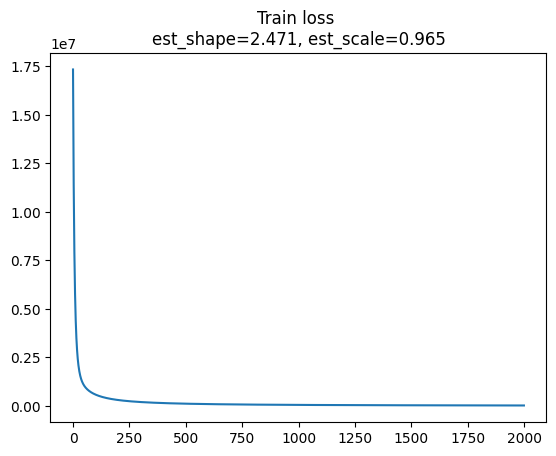

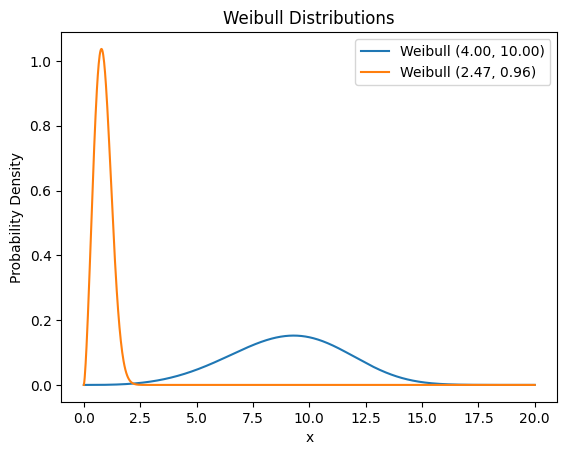

Actual shape=4


In [11]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 

iter 0: 0.0377502515912056, 1.9518752098083496, 39406.616882119226
iter 100: 0.16388778388500214, 1.7587199211120605, 691.8878843513046
iter 200: 0.19012294709682465, 1.6819931268692017, 438.0060143511693
iter 300: 0.2099267989397049, 1.6202318668365479, 318.3313262506241
iter 400: 0.22572535276412964, 1.569071888923645, 250.51920244384905
iter 500: 0.2388610690832138, 1.5255825519561768, 207.42566889026995
iter 600: 0.2501038610935211, 1.4879224300384521, 177.9021714299074
iter 700: 0.2599319815635681, 1.4548665285110474, 156.57986298476976
iter 800: 0.26866230368614197, 1.42555832862854, 140.5683597233353
iter 900: 0.27651649713516235, 1.3993726968765259, 128.1779583005789
iter 1000: 0.2836553156375885, 1.3758348226547241, 118.35763265162248
iter 1100: 0.2901991307735443, 1.3545771837234497, 110.42110462852354
iter 1200: 0.29624083638191223, 1.3353054523468018, 103.90144713067586
iter 1300: 0.30185362696647644, 1.3177800178527832, 98.47073117059409
iter 1400: 0.3

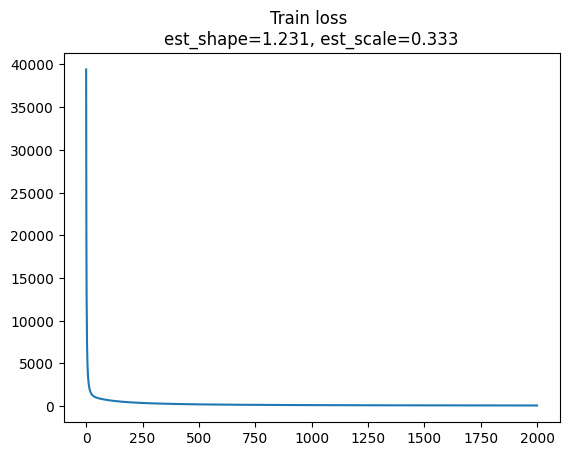

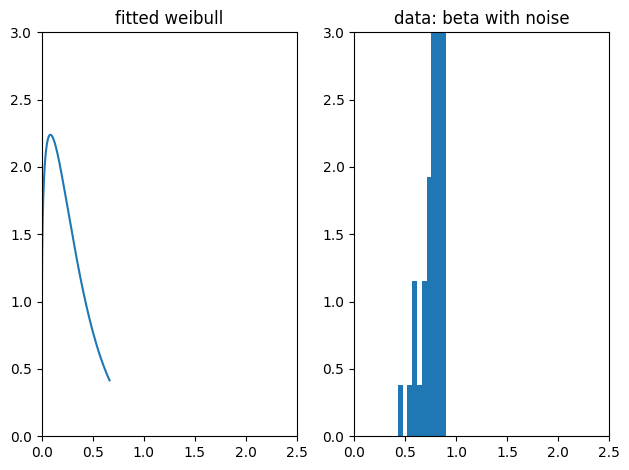

In [12]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS optimizer on Weibull data 


--------
scale, shape, loss 

iter 0: 1.5906901359558105, 1.4287192821502686, 1175.5350137759447
iter 0: 1.6248915195465088, 1.3629206418991089, 1027.766380630394
iter 0: 1.6378675699234009, 1.329972505569458, 966.790697790049
iter 0: 1.648482322692871, 1.2930538654327393, 907.2069597202619
iter 0: 1.6559288501739502, 1.2542020082473755, 852.4836156732731
iter 0: 1.6602110862731934, 1.2135496139526367, 802.3560282518417
iter 0: 1.6613719463348389, 1.1713917255401611, 756.7201758718759
iter 0: 1.6595317125320435, 1.128087043762207, 715.4603577258131
iter 0: 1.6548949480056763, 1.084060549736023, 678.4493754992413
iter 0: 1.6477528810501099, 1.0397926568984985, 645.539435468017
iter 0: 1.6384793519973755, 0.9958025217056274, 616.5549656912801
iter 0: 1.6275179386138916, 0.9526234865188599, 591.2868766330814
iter 0: 1.615361213684082, 0.9107732772827148, 569.4899929192319
iter 0: 1.6025229692459106, 0.8707219958305359, 550.8847828402845
iter 0: 1.5895074605941772, 0.8328642249107361, 535

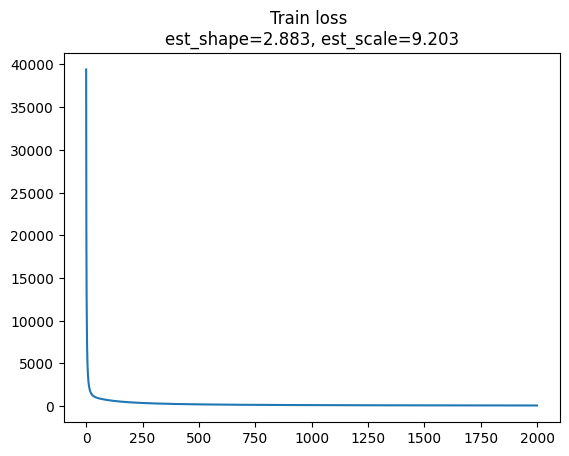

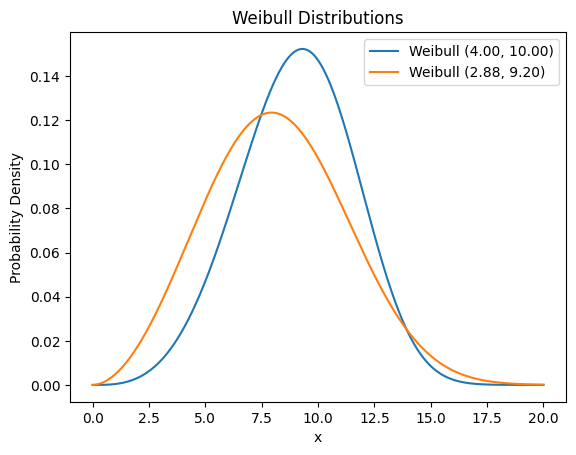

Actual shape=4

--------
scale, shape, loss 

iter 0: 9.202688217163086, 2.8825109004974365, 232.67965055325823
iter 0: 9.252175331115723, 2.9761598110198975, 230.88157579815874
iter 0: 9.325782775878906, 3.0919904708862305, 228.80881870606527
iter 0: 9.393071174621582, 3.2012670040130615, 227.04748289165985
iter 0: 9.451011657714844, 3.3047409057617188, 225.5544953003228
iter 0: 9.501117706298828, 3.402351140975952, 224.29187149089714
iter 0: 9.544846534729004, 3.4941039085388184, 223.22621956798073
iter 0: 9.583276748657227, 3.580061435699463, 222.3289102192339
iter 0: 9.617237091064453, 3.6603288650512695, 221.57527556336115
iter 0: 9.647377967834473, 3.7350523471832275, 220.94395017757475
iter 0: 9.67421817779541, 3.804412603378296, 220.41646128507358
iter 0: 9.698183059692383, 3.8686211109161377, 219.97681636054023
iter 0: 9.719624519348145, 3.9279098510742188, 219.61127438602242
iter 0: 9.73884105682373, 3.9825289249420166, 219.30801936382932
iter 0: 9.756082534790039, 4.03273820

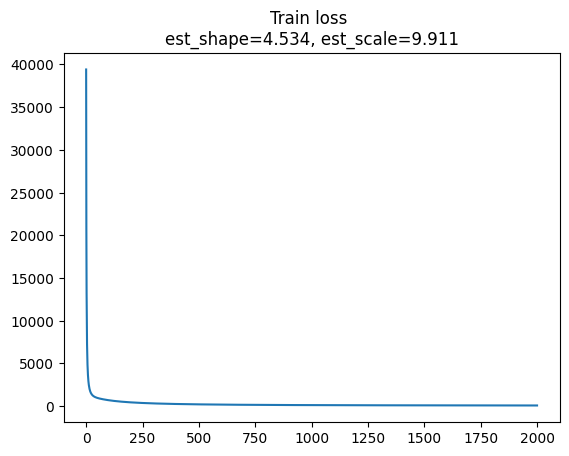

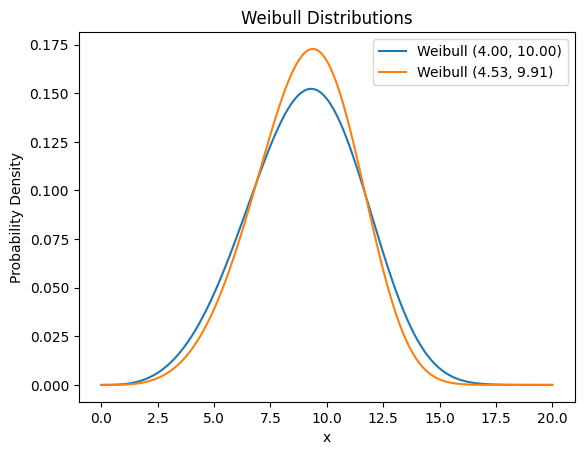

Actual shape=4


In [13]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)


for data in [weibull_tensor, weibull_left_trunc_tensor]: 
    print('\n--------')
    # Training loop
    print('scale, shape, loss \n')
    num_iterations = 2000
    for i in range(num_iterations):
        def closure():
            optimizer.zero_grad()
            weibull_pdf = model2(data)
            lambda_, k = model2.weights
            loss = weibull_nll(data, lambda_, k)
            loss.backward()
            if i % 100 == 0 or i == num_iterations-1: 
                print(f'iter {i}: {lambda_}, {k}, {loss}')
            return loss

        optimizer.step(closure)

    fitted_params = model2.weights
    estimated_scale = fitted_params.detach().numpy()[0]
    estimated_shape = fitted_params.detach().numpy()[1]
    print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
    print(f'\nActual params: shape={shape}, scale={scale}')
    print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
    print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

    txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
    plt.plot(losses)
    plt.title(txt)
    # plt.ylim(bottom=0)
    plt.show()

    plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
    print(f'Actual shape={shape}')

****
# Using LBFGS optimizer on Beta data 

scale, shape, loss 

iter 0: 3.909038782119751, 1.5270771980285645, 103.1240238754949
iter 0: 3.878594398498535, 1.457521677017212, 99.5329139357159
iter 0: 3.8239524364471436, 1.3628649711608887, 94.8316229995984
iter 0: 3.7636454105377197, 1.2885730266571045, 91.25105821280516
iter 0: 3.694432258605957, 1.2298049926757812, 88.37867060063562
iter 0: 3.610828161239624, 1.181040644645691, 85.84169897657785
iter 0: 3.5053298473358154, 1.1383605003356934, 83.3659468325453
iter 0: 3.366507053375244, 1.0988211631774902, 80.70363352129723
iter 0: 3.1755518913269043, 1.0598987340927124, 77.56254666347434
iter 0: 2.8987812995910645, 1.0188663005828857, 73.49772170424693
iter 0: 2.469317674636841, 0.9717543721199036, 67.67994666550827
iter 0: 1.7571043968200684, 0.9127483367919922, 58.64681663311134
iter 0: 0.9835619926452637, 0.8655204176902771, 50.807639650526205
iter 0: 0.9224191308021545, 0.8667457699775696, 50.273755942607345
iter 0: 0.8931537866592407, 0.8745226263999939, 49.6188289125886

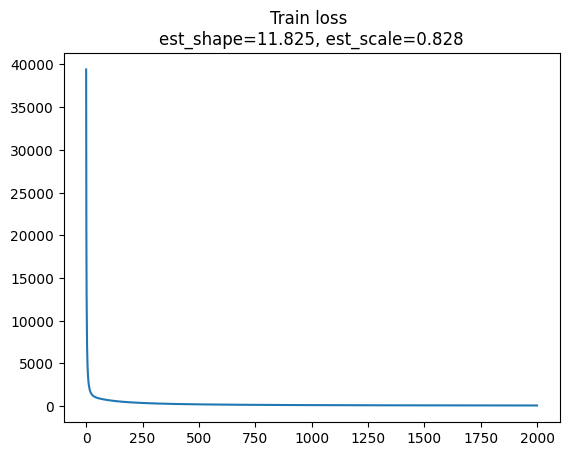

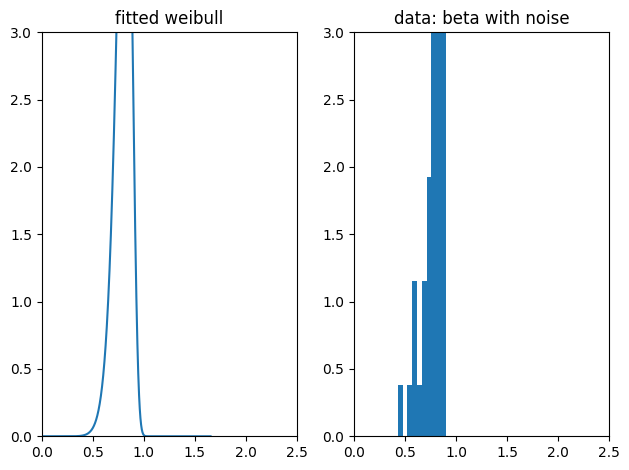

In [14]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(beta_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(beta_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}' 
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()

****
# Random stuff 

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


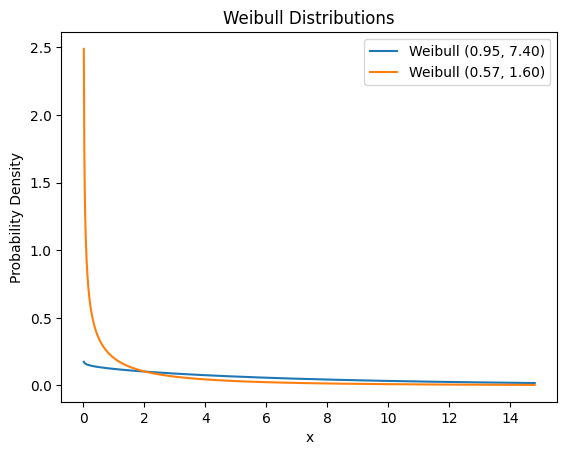

In [15]:
plot_weibull_distributions((.95, 7.4), (.57, 1.6))